In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network

from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
#from env.RideSimulator.Grid import Grid
import tf_agents

#soft actor critic agent
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation


In [2]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper params

num_iterations = 30 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    


In [6]:
#catagorical dqn agent
gamma = 0.99
num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

In [11]:
print(tf_env.action_spec())

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))


In [9]:
#soft actor critic

#hyper parameters
critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

#agent networks
critic_net = critic_network.CriticNetwork(
    (tf_env.observation_spec(), tf_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

def normal_projection_net(action_spec, init_means_output_factor=0.1):
  return normal_projection_network.NormalProjectionNetwork(
      action_spec,
      mean_transform=None,
      state_dependent_std=True,
      init_means_output_factor=init_means_output_factor,
      std_transform=sac_agent.std_clip_transform,
      scale_distribution=True)


actor_net = actor_distribution_network.ActorDistributionNetwork(
     tf_env.time_step_spec(),
     tf_env.action_spec(),
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=normal_projection_net)

#agent
global_step = tf.compat.v1.train.get_or_create_global_step()
tf_agent = sac_agent.SacAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)
tf_agent.initialize()

ValueError: preprocessing_combiner layer is required when more than 1 input_tensor_spec is provided.
  In call to configurable 'EncodingNetwork' (<function EncodingNetwork.__init__ at 0x7fa02ddfd1f0>)
  In call to configurable 'ActorDistributionNetwork' (<function ActorDistributionNetwork.__init__ at 0x7fa02de15670>)

In [7]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [8]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [9]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation(acceptPol)
#print(eval_env)

init


In [10]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)

evaluatePolicy(acceptPol, eval_env)

-140
105
200
50
-5
70
-55
100
125
-5
90
80
150
25
75
-50
0
135
0
10
45
70
35
10
110
50
10
145
-10
95
105
125
175
140
-100
160
driver reward  2125
70
25
50
15
140
175
5
130
45
60
120
-25
-5
-20
210
40
75
200
135
40
40
105
110
40
-40
100
85
55
190
70
140
20
40
55
70
30
75
10
110
530
570
driver reward  3890
60
155
70
25
50
-20
50
170
0
105
-10
-60
185
30
100
155
125
85
235
55
70
40
10
70
110
95
185
70
155
-15
75
5
55
155
45
55
75
95
40
driver reward  2955
-15
175
15
110
-25
165
70
35
165
5
115
235
165
180
105
85
5
100
-50
-50
65
100
25
20
25
240
-60
-40
-10
125
250
25
85
-5
60
125
105
35
65
575
610
595
575
560
600
driver reward  6340
55
165
-50
240
135
60
235
250
230
95
150
115
115
35
65
100
140
170
25
110
100
100
-40
10
-35
125
105
265
100
40
40
50
75
125
195
15
245
165
70
driver reward  4190
0
15
115
185
5
125
90
15
60
20
95
80
305
55
110
60
-35
45
45
105
155
140
60
-20
60
-75
160
60
85
5
220
170
70
60
140
50
65
175
65
595
565
505
635
525
605
driver reward  6570
65
60
-80
110
120
285
14

In [11]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation(policy)
        episode_reward = 0
        for state_list in state_lists:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()


In [12]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation(policy)
        print("driver count : ", len(state_lists))
        for state_list in state_lists:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]

                #print (action)
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)

        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [13]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

tf.Tensor(4606.25, shape=(), dtype=float32)
 Average Return = 4606.25
driver count :  20
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


driver count :  20
driver count :  20
driver count :  20
driver count :  20
tf.Tensor(4419.875, shape=(), dtype=float32)
step = 5: Average Return = 4419.875
evaluation
driver count :  20
driver count :  20
driver count :  20
driver count :  20
driver count :  20
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=1.6583428>, extra=DqnLossInfo(td_loss=(), td_error=()))
tf.Tensor(4103.375, shape=(), dtype=float32)
step = 10: Average Return = 4103.375
evaluation
driver count :  20
driver count :  20
driver count :  20
driver count :  20
driver count :  20
tf.Tensor(-598.75, shape=(), dtype=float32)
step = 15: Average Return = -598.75
evaluation
driver count :  20
driver count :  20
driver count :  20
driver count :  20
driver count :  20
step = 20: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=1.0880823>, extra=DqnLossInfo(td_loss=(), td_error=()))
tf.Tensor(11484.125, shape=(), dtype=float32)
step = 20: Average Return = 11484.125
evaluation
driver

Text(0.5, 0, 'Iterations')

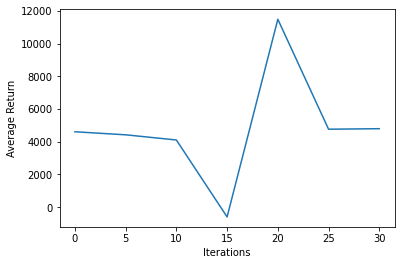

In [15]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [53]:
#run_simulation(eval_policy)
evaluatePolicy(eval_policy, eval_env)

47.5
41.0
13.5
-5.5
52.5
21.5
62.5
17.0
0
59.0
33.5
-3.0
131.0
52.5
0
156.5
67.0
61.0
0
27.0
-1.5
13.0
44.0
48.5
0
31.5
93.5
0
137.5
139.0
151.5
3.5
0
22.5
62.5
0
0
151.5
123.0
511.5
driver reward  2366.0
14.0
0
0
93.0
66.5
67.0
95.5
100.0
60.0
3.0
19.0
0
53.0
20.0
117.5
105.5
0
61.0
78.5
0
11.0
70.5
12.0
0
-7.0
75.5
0
0
4.5
60.5
104.0
31.0
37.0
0
0
125.0
6.5
44.0
driver reward  1528.0
-19.0
0.0
100.0
0
94.0
0
60.0
38.0
8.0
29.5
0
0
6.0
45.5
72.5
12.5
177.5
0
52.0
0
98.5
64.5
47.5
0
3.0
83.5
70.5
2.0
25.5
-3.5
0
10.0
0
-1.0
38.0
5.0
0
driver reward  1120.0
46.5
77.5
60.5
84.0
94.5
75.0
1.5
0
74.0
141.0
54.0
59.5
0
64.0
76.0
20.5
-28.0
49.0
103.5
0
0
37.0
25.5
0
-9.5
0
14.0
0
-21.5
21.0
83.0
50.0
78.0
54.0
0
27.0
0
35.0
40.5
580.5
511.5
577.5
571.5
driver reward  3728.0
55.5
10.0
0
8.0
8.0
60.5
18.0
125.5
42.0
134.5
21.5
-20.0
0
117.0
0
29.5
9.5
2.0
0
0
-23.0
72.0
7.5
0
85.5
72.0
104.0
0
110.0
-5.0
0
driver reward  1044.5
58.5
149.0
46.0
60.0
0
0
0
0
120.5
49.0
0
0
49.0
132.5
157.0
-15.

In [1]:
"""
reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""

##############################################################################################














'\nreward results - \nrandom policy - around 9.5k\nlearned policy - 14k\nalways accept policy - 19.4k\n'

In [2]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [3]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

NameError: name 'tf' is not defined

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""